In [4]:
!pip install pycox

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install torchtuples

In [6]:
import torch
import torchtuples as tt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

import numpy as np
import os
import pandas as pd
from typing import Optional

In [7]:
np.random.seed(1234)
_ = torch.manual_seed(123)

Load the Data

In [8]:
main_path = r'/content/drive/MyDrive'
Survival_Data = pd.read_excel(os.path.join(main_path, 'survival_data/survival1.xlsx'), sheet_name='TCGA-CDR', usecols="A,B,Y, Z")
#Survival_Data.dropna(inplace=True)
img_list = pd.read_csv(os.path.join(main_path, 'Image-data/IMG-LIST.csv'))
image = pd.merge(img_list, Survival_Data, on='EnsemblgeneID')

In [9]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1024
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 20
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    volume = volume.T
    return volume

In [10]:
abnormal_scan_paths = [
    os.path.join(main_path, "Image-data/CT_patch", x)
    for x in os.listdir(os.path.join(main_path, "Image-data/CT_patch"))
]

print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with abnormal lung tissue: 90


In [11]:
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])

patient_name = []
abnormal_labels = np.zeros([len(abnormal_scan_paths), 2])
for i in range(len(abnormal_scan_paths)):
    str1 = str.split(abnormal_scan_paths[i], '/')[-1]
    index = np.where(Survival_Data.values[:, 0] == str.split(str1, '.')[0])[0]
    patient_name.append(Survival_Data.values[index, 0])# 
    abnormal_labels[i, :] = Survival_Data.values[index, 2:4]#
    



In [12]:
abnormal_scans.shape

(90, 20, 128, 128)

In [13]:
X= abnormal_scans
y = abnormal_labels
#y_train = tuple([y_train[:, 0], y_train[:, 1]])
print("Number of samples in train are %d." % (X.shape[0]))

Number of samples in train are 90.


In [14]:
X = np.expand_dims(X, axis=1)

In [15]:
X.shape

(90, 1, 20, 128, 128)

Define the model

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv3d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout3d()
        self.fc1 = nn.Linear(54000, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # print(x.shape)
        x = F.relu(F.max_pool3d(self.conv1(x), 2))
        x = F.relu(F.max_pool3d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

net = CNN()
print(net)

CNN(
  (conv1): Conv3d(1, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (conv2): Conv3d(10, 20, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (conv2_drop): Dropout3d(p=0.5, inplace=False)
  (fc1): Linear(in_features=54000, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [17]:
class ConvNet(nn.Module):
    def __init__(self,h1=96):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout3d(p=0.5)  
        
        self.fc1 = nn.Linear(32 * 7 * 7, h1)
        self.drop2=nn.Dropout3d(p=0.1)
        self.fc2 = nn.Linear(h1, 10)

    def forward(self, x):
        x = F.relu(F.max_pool3d(self.conv1(x),kernel_size = 2))
        x = F.relu(F.max_pool3d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)

        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        return self.fc2(x)

In [25]:
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook
#get_target = lambda df_clinic: (df_clinic['OS.time'].values, df_clinic['OS'].values)

0:	[7s / 7s],		train_loss: 1.2040,	val_loss: 1.0143
1:	[7s / 14s],		train_loss: 1.1757,	val_loss: 1.0180
2:	[6s / 21s],		train_loss: 1.2682,	val_loss: 1.0237
3:	[6s / 28s],		train_loss: 1.1914,	val_loss: 1.0252
4:	[7s / 35s],		train_loss: 1.1718,	val_loss: 1.0311
5:	[7s / 42s],		train_loss: 1.2508,	val_loss: 1.0375
6:	[6s / 49s],		train_loss: 1.1287,	val_loss: 1.0397
7:	[7s / 56s],		train_loss: 1.1798,	val_loss: 1.0427
8:	[7s / 1m:3s],		train_loss: 1.1732,	val_loss: 1.0467
9:	[7s / 1m:10s],		train_loss: 1.1339,	val_loss: 1.0484
10:	[6s / 1m:17s],		train_loss: 1.1006,	val_loss: 1.0516
1 Image C-Index 0.8499542543458372
0:	[7s / 7s],		train_loss: 1.2781,	val_loss: 1.3747
1:	[8s / 15s],		train_loss: 1.4484,	val_loss: 1.3698
2:	[7s / 23s],		train_loss: 1.2552,	val_loss: 1.3796
3:	[7s / 30s],		train_loss: 1.3102,	val_loss: 1.3816
4:	[7s / 38s],		train_loss: 1.2941,	val_loss: 1.3865
5:	[7s / 45s],		train_loss: 1.3001,	val_loss: 1.3871
6:	[8s / 54s],		train_loss: 1.1773,	val_loss: 1.3828
7:	[

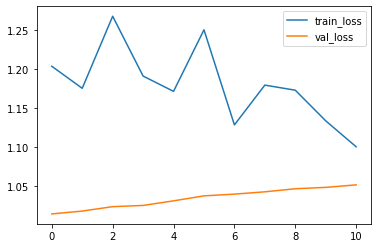

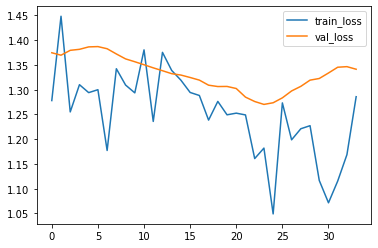

In [26]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
in_features = X.shape[1]
verbose = True
batch_size = 8
epochs = 50
out_features = 1
index_test = []
feature_vectore = np.zeros([0, 32], dtype=np.float32)

cv = KFold(n_splits=2, shuffle=True, random_state=10)
i=1
for train_ix, test_ix in cv.split(X):
	
	# split data
	x_train, X_test = X[train_ix, :], X[test_ix, :]
	y_train, y_test = y[train_ix, :],y[test_ix, :]
  #tuple([y[train_ix, 0], y[train_ix, 1]]),tuple([y[test_ix, 0], y[test_ix, 1]])
	# get validation set
	X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=10)

	# Normalise data
	#X_train,X_val,X_test = normalize(X_train,X_val,X_test)
	#X_test = normalize(X_test)
	#X_val = normalize(X_val)
	#print('Train, val, test shape run:', i, X_train.shape, X_val.shape, X_test.shape)
 
	# convert to event + duration
	y_train = tuple([y_train[:, 0], y_train[:, 1]])
	y_test = tuple([y_test[:, 0], y_test[:, 1]])
	y_val = tuple([y_val[:, 0], y_val[:, 1]])
	val_g = X_val, y_val
	durations_test, events_test = y_test[0][:], y_test[1][:]
	# Model
	torch.manual_seed(56) 
	net = CNN()
 # print(net)
	# Same output number
	model = CoxPH(net, tt.optim.Adam)
	# model.optimizer.set_lr(0.01)
	model.optimizer.set_lr(1e-4)
	# lrfinder = model.lr_finder(X_train, y_train, batch_size, tolerance=10)
	# lrfinder.get_best_lr()
 

	callbacks = [tt.callbacks.EarlyStopping()]
	
	log = model.fit(X_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val_g, val_batch_size=batch_size)

	_ = log.plot()

	features = {}
	model.net.fc1.register_forward_hook(get_features('fc1'))
	_ = model.compute_baseline_hazards()
	surv = model.predict_surv_df(X_test)

	#  Feature extraction
	extracted = features['fc1'].cpu().numpy()
	feature_vectore = np.append(feature_vectore, extracted, axis=0)

	ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
	print(i, "Image C-Index", ev.concordance_td())
	i+=1
	index_test = np.append(index_test, test_ix)
  
 
   



In [ ]:
#patient_name

In [ ]:
#bb=np.concatenate((patient_name,X_validation_feature), axis=1)
#np.savetxt("/content/drive/MyDrive/Feature-vector/patient_IMG_83.csv", bb, delimiter=",",fmt='%s')